Initialisation stage

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib.dates as mdates
import numpy as np
import time
import seaborn as sns
import math
from datetime import timedelta, date

import project_01 as p1

We read a weekly file (week ending 2 Feb 2019) from the MTA website to determine its structure

This instead reads num_weeks weeks of data starting from week ending 2 Feb 2019

In [89]:
num_weeks = 1
start_date = filedate = pd.Timestamp('2019-02-02 00:00:00') 

dateparse = lambda dates: [time.strptime(d, '%m/%d/%Y') for d in dates]

filelist = []
for numfiles in range (num_weeks):

    df = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_' + str(filedate.year)[2:4] + str(filedate.month).zfill(2) + str(filedate.day).zfill(2) + '.txt', parse_dates=['DATE'])
    filelist.append(df)
    filedate += pd.Timedelta(days=7)

mta_test = pd.concat(filelist, axis=0, ignore_index=True)


In [90]:
mta_test.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-26,03:00:00,REGULAR,6922652,2347673
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-26,07:00:00,REGULAR,6922669,2347688
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-26,11:00:00,REGULAR,6922747,2347773
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-26,15:00:00,RECOVR AUD,6922932,2347849
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-26,19:00:00,REGULAR,6923237,2347911


The 'ENTRIES' column name is dirty!

In [91]:
mta_test.columns.values

array(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE',
       'TIME', 'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype=object)

Rename the column

In [92]:
mta_test.rename(columns={'EXITS                                                               ':'EXITS'}, inplace=True)

In [93]:
mta_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202912 entries, 0 to 202911
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   C/A       202912 non-null  object        
 1   UNIT      202912 non-null  object        
 2   SCP       202912 non-null  object        
 3   STATION   202912 non-null  object        
 4   LINENAME  202912 non-null  object        
 5   DIVISION  202912 non-null  object        
 6   DATE      202912 non-null  datetime64[ns]
 7   TIME      202912 non-null  object        
 8   DESC      202912 non-null  object        
 9   ENTRIES   202912 non-null  int64         
 10  EXITS     202912 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 17.0+ MB


We found that the DESC column has a small amout of 'RECOVR AUD', which we learned refers to audits updated 

In [94]:
mta_test['DESC'].value_counts()

REGULAR       201952
RECOVR AUD       960
Name: DESC, dtype: int64

The names of stations are not in a consistant format

In [95]:
mta_test['STATION'].value_counts().head(20)

34 ST-PENN STA     4195
FULTON ST          4016
23 ST              3081
GRD CNTRL-42 ST    2955
CANAL ST           2476
86 ST              2467
34 ST-HERALD SQ    2295
CHAMBERS ST        2266
59 ST              2149
42 ST-PORT AUTH    2142
WALL ST            2135
TIMES SQ-42 ST     2134
ATL AV-BARCLAY     2032
125 ST             1810
PATH NEW WTC       1774
59 ST COLUMBUS     1722
14 ST              1690
28 ST              1654
14 ST-UNION SQ     1638
CORTLANDT ST       1625
Name: STATION, dtype: int64

In [96]:
mta_test['TIME'].value_counts()

03:00:00    17249
07:00:00    17243
19:00:00    17221
15:00:00    17217
23:00:00    17213
            ...  
16:44:42        1
12:00:51        1
18:57:28        1
13:08:47        1
14:11:10        1
Name: TIME, Length: 12614, dtype: int64

Grouping by Station, C/A, unit, SCP (and optionally date), and then taking the difference between max and min of entry and exit counters

In [97]:

(mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.max() - mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.min())

STATION    C/A   UNIT  SCP       DATE      
1 AV       H007  R248  00-00-00  2019-01-26    2753
                                 2019-01-27    2070
                                 2019-01-28    3842
                                 2019-01-29    4201
                                 2019-01-30    4274
                                               ... 
ZEREGA AV  R419  R326  00-05-01  2019-01-28       0
                                 2019-01-29       0
                                 2019-01-30       0
                                 2019-01-31       0
                                 2019-02-01       0
Name: ENTRIES, Length: 33631, dtype: int64

In [98]:
mta_test['EXITS']

0         2347673
1         2347688
2         2347773
3         2347849
4         2347911
           ...   
202907        368
202908        368
202909        368
202910        368
202911        368
Name: EXITS, Length: 202912, dtype: int64

In [99]:
## gets the number of entries and exits
mta_entries = mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.max() - mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).ENTRIES.min()

mta_exits = mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).EXITS.max() - mta_test.groupby(['STATION','C/A','UNIT','SCP','DATE']).EXITS.min()


This is what the grouped data looks like before flattening

In [100]:
print(mta_entries)
print(mta_exits)

STATION    C/A   UNIT  SCP       DATE      
1 AV       H007  R248  00-00-00  2019-01-26    2753
                                 2019-01-27    2070
                                 2019-01-28    3842
                                 2019-01-29    4201
                                 2019-01-30    4274
                                               ... 
ZEREGA AV  R419  R326  00-05-01  2019-01-28       0
                                 2019-01-29       0
                                 2019-01-30       0
                                 2019-01-31       0
                                 2019-02-01       0
Name: ENTRIES, Length: 33631, dtype: int64
STATION    C/A   UNIT  SCP       DATE      
1 AV       H007  R248  00-00-00  2019-01-26    3718
                                 2019-01-27    3120
                                 2019-01-28    3597
                                 2019-01-29    3831
                                 2019-01-30    3534
                                     

Flatten and merge the entry and exit datasets

In [101]:
mta_entries_flat = mta_entries.reset_index()
mta_exits_flat = mta_exits.reset_index()

mta_entries_exits = pd.merge(mta_entries_flat, mta_exits_flat, how='outer')
print(mta_entries_exits)

STATION   C/A  UNIT       SCP       DATE  ENTRIES  EXITS
0           1 AV  H007  R248  00-00-00 2019-01-26     2753   3718
1           1 AV  H007  R248  00-00-00 2019-01-27     2070   3120
2           1 AV  H007  R248  00-00-00 2019-01-28     3842   3597
3           1 AV  H007  R248  00-00-00 2019-01-29     4201   3831
4           1 AV  H007  R248  00-00-00 2019-01-30     4274   3534
...          ...   ...   ...       ...        ...      ...    ...
33626  ZEREGA AV  R419  R326  00-05-01 2019-01-28        0      0
33627  ZEREGA AV  R419  R326  00-05-01 2019-01-29        0      0
33628  ZEREGA AV  R419  R326  00-05-01 2019-01-30        0      0
33629  ZEREGA AV  R419  R326  00-05-01 2019-01-31        0      0
33630  ZEREGA AV  R419  R326  00-05-01 2019-02-01        0      0

[33631 rows x 7 columns]


Append weekday and traffic column to dataset

In [102]:
mta_entries_exits['WEEKDAY'] = mta_entries_exits['DATE'].dt.day_name()
mta_entries_exits['TRAFFIC'] = mta_entries_exits['ENTRIES'] + mta_entries_exits['EXITS']
mta_entries_exits['WEEKDAY_INDEX'] = mta_entries_exits['DATE'].dt.weekday

Remove rows with erronous jumps

In [103]:
mta_entries_exits = mta_entries_exits[mta_entries_exits.TRAFFIC < 50000]

Group by station and date (including weekday) and flatten the resultant dataset

In [104]:
mta_bystation = mta_entries_exits.groupby(['STATION','DATE','WEEKDAY', 'WEEKDAY_INDEX']).sum().reset_index()

In [105]:
mta_bystation

,STATION,DATE,WEEKDAY,WEEKDAY_INDEX,ENTRIES,EXITS,TRAFFIC
0,1 AV,2019-01-26,Saturday,5,15001,18465,33466
1,1 AV,2019-01-27,Sunday,6,11887,14116,26003
2,1 AV,2019-01-28,Monday,0,18617,21205,39822
3,1 AV,2019-01-29,Tuesday,1,19714,23064,42778
4,1 AV,2019-01-30,Wednesday,2,19708,22868,42576
...,...,...,...,...,...,...,...
2637,ZEREGA AV,2019-01-28,Monday,0,2637,2074,4711
2638,ZEREGA AV,2019-01-29,Tuesday,1,2754,2298,5052
2639,ZEREGA AV,2019-01-30,Wednesday,2,2715,2248,4963
2640,ZEREGA AV,2019-01-31,Thursday,3,2207,1836,4043


In [106]:
mta_bystation[mta_bystation.STATION == "34 ST-PENN STA"]

,STATION,DATE,WEEKDAY,WEEKDAY_INDEX,ENTRIES,EXITS,TRAFFIC
427,34 ST-PENN STA,2019-01-26,Saturday,5,77849,75662,153511
428,34 ST-PENN STA,2019-01-27,Sunday,6,66531,63272,129803
429,34 ST-PENN STA,2019-01-28,Monday,0,161183,145887,307070
430,34 ST-PENN STA,2019-01-29,Tuesday,1,169162,155165,324327
431,34 ST-PENN STA,2019-01-30,Wednesday,2,165812,153787,319599
432,34 ST-PENN STA,2019-01-31,Thursday,3,157907,143326,301233
433,34 ST-PENN STA,2019-02-01,Friday,4,157598,148396,305994


Which are the top 5 stations by entries and exits?

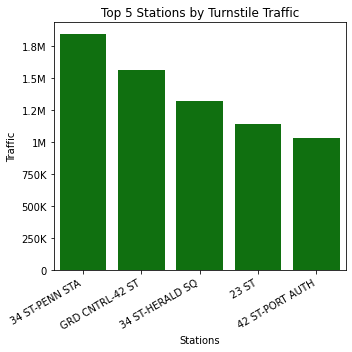

In [107]:
mta_top5 = mta_bystation.groupby('STATION').sum().reset_index().sort_values('TRAFFIC', ascending=False).head(5)

fig = plt.figure(figsize=(5,5))
sns.barplot(data=mta_top5, x = 'STATION', y = 'TRAFFIC', color='green').set(title='Top 5 Stations by Turnstile Traffic', xlabel='Stations', ylabel='Traffic')
axs = plt.gca()
axs.yaxis.set_major_formatter(tick.FuncFormatter(p1.reformat_large_tick_values));
plt.xticks(rotation=30, ha='right')
plt.tight_layout()

plt.savefig('top5stations-' + str(num_weeks) + 'wk.svg')


In [108]:
mta_entries_exits.sort_values('TRAFFIC', ascending=False).head(30)

,STATION,C/A,UNIT,SCP,DATE,ENTRIES,EXITS,WEEKDAY,TRAFFIC,WEEKDAY_INDEX
31106,THIRTY ST,PTH13,R541,00-00-05,2019-01-28,21577,28151,Monday,49728,0
28574,PATH NEW WTC,PTH22,R540,00-00-05,2019-02-01,31897,16888,Friday,48785,4
28578,PATH NEW WTC,PTH22,R540,00-00-06,2019-01-29,27141,14145,Tuesday,41286,1
28566,PATH NEW WTC,PTH22,R540,00-00-04,2019-01-31,6009,11848,Thursday,17857,3
7156,42 ST-PORT AUTH,N063A,R011,00-00-00,2019-01-30,3218,9889,Wednesday,13107,2
7155,42 ST-PORT AUTH,N063A,R011,00-00-00,2019-01-29,2357,10562,Tuesday,12919,1
7158,42 ST-PORT AUTH,N063A,R011,00-00-00,2019-02-01,2746,9936,Friday,12682,4
7157,42 ST-PORT AUTH,N063A,R011,00-00-00,2019-01-31,3265,9367,Thursday,12632,3
7154,42 ST-PORT AUTH,N063A,R011,00-00-00,2019-01-28,2460,10054,Monday,12514,0
22298,GRD CNTRL-42 ST,R240,R047,00-00-00,2019-01-29,2059,10142,Tuesday,12201,1


In [109]:
mta_entries_flat[(mta_entries_flat.STATION == '125 ST') & (mta_entries_flat.DATE == pd.Timestamp('2019-01-30 00:00:00'))]

,STATION,C/A,UNIT,SCP,DATE,ENTRIES
669,125 ST,N025,R102,01-00-00,2019-01-30,1238
676,125 ST,N025,R102,01-00-01,2019-01-30,1114
683,125 ST,N025,R102,01-00-02,2019-01-30,1104
690,125 ST,N025,R102,01-00-03,2019-01-30,993
697,125 ST,N025,R102,01-00-04,2019-01-30,1859
704,125 ST,N025,R102,01-06-00,2019-01-30,700
711,125 ST,N026,R102,00-00-00,2019-01-30,3434
718,125 ST,N026,R102,00-00-01,2019-01-30,2941
725,125 ST,N026,R102,00-00-02,2019-01-30,2052
732,125 ST,N026,R102,00-00-03,2019-01-30,1364


There are big unexplained jumps in counter numbers at certain parts of the data (see last three rows below)

In [110]:
filter = (mta_test['STATION'] == '125 ST') & (mta_test['C/A'] == 'R258') & (mta_test['SCP'] == '00-03-03')
mta_test[filter].head(30) 

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
164231,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,00:00:00,REGULAR,3888393,2659898
164232,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,04:00:00,REGULAR,3888433,2659961
164233,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,08:00:00,REGULAR,3888523,2660074
164234,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,12:00:00,REGULAR,3888767,2660272
164235,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,16:00:00,REGULAR,3889047,2660460
164236,R258,R132,00-03-03,125 ST,456,IRT,2019-01-26,20:00:00,REGULAR,3889323,2660636
164237,R258,R132,00-03-03,125 ST,456,IRT,2019-01-27,00:00:00,REGULAR,3889445,2660788
164238,R258,R132,00-03-03,125 ST,456,IRT,2019-01-27,04:00:00,REGULAR,3889476,2660850
164239,R258,R132,00-03-03,125 ST,456,IRT,2019-01-27,08:00:00,REGULAR,3889520,2660934
164240,R258,R132,00-03-03,125 ST,456,IRT,2019-01-27,12:00:00,REGULAR,3889667,2661092


Plot the traffic for top 5 stations; weekends are highlighted 

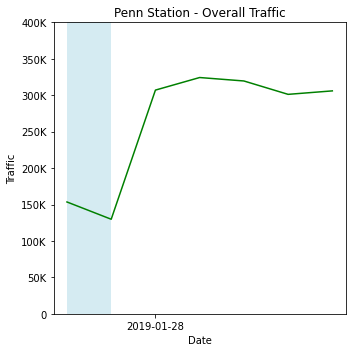

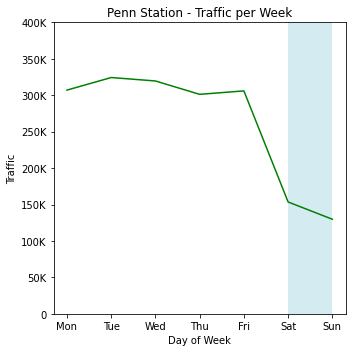

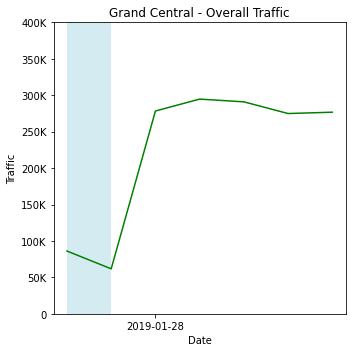

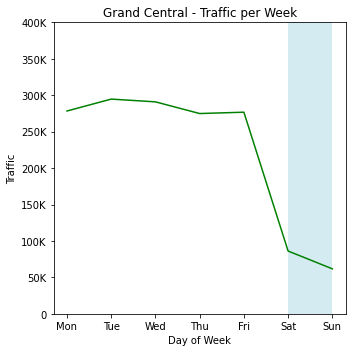

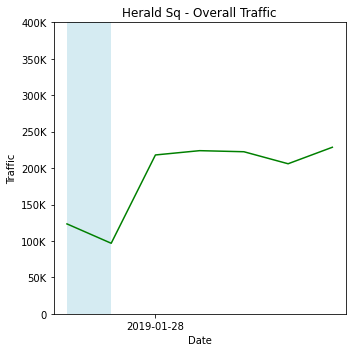

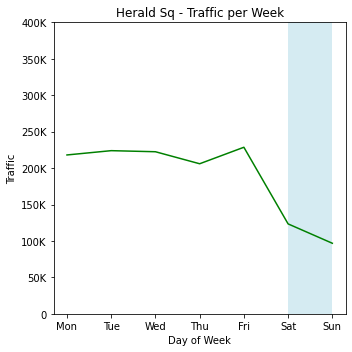

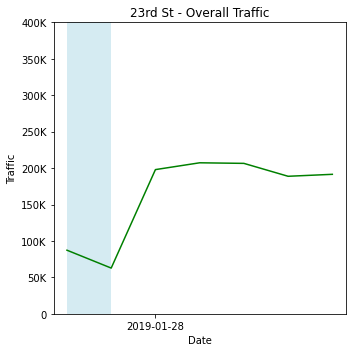

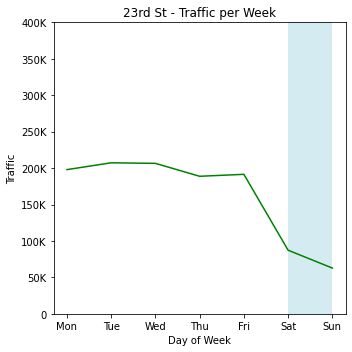

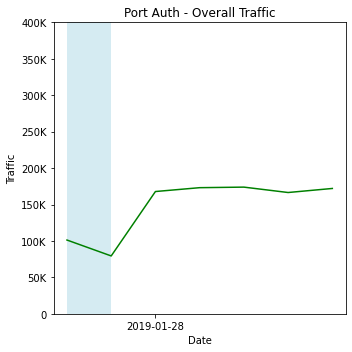

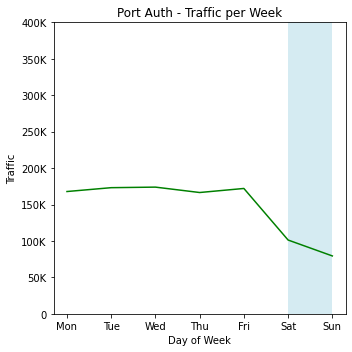

In [131]:
mta = {}
plot_num = 0

mta['penn'] = [mta_bystation[mta_bystation.STATION == "34 ST-PENN STA"], 'Penn Station']
mta['grdcntrl'] = [mta_bystation[mta_bystation.STATION == "GRD CNTRL-42 ST"], 'Grand Central']
mta['heraldsq'] = [mta_bystation[mta_bystation.STATION == "34 ST-HERALD SQ"], 'Herald Sq']
mta['23rd'] = [mta_bystation[mta_bystation.STATION == "23 ST"], '23rd St']
mta['portauth'] = [mta_bystation[mta_bystation.STATION == "42 ST-PORT AUTH"], 'Port Auth']
#mta['unionsq'] = [mta_bystation[mta_bystation.STATION == "14 ST-UNION SQ"], 'Union Sq']
#mta['timessq'] = [mta_bystation[mta_bystation.STATION == "TIMES SQ-42 ST"], 'Times Sq']

for station in mta:
    
    '''
    plot total traffic for each top 5 station over the whole time period
    '''

    # scale width of plot logrimatically with number of weeks
    fig, axs = plt.subplots(nrows=1, figsize=(int(10.75*math.log2(1.38 * num_weeks)),5))
    sns.lineplot(data = mta[station][0], x='DATE', y='TRAFFIC', color='green', ax=axs).set(ylim=(0,400000),title=mta[station][1] + ' - Overall Traffic', xlabel='Date', ylabel='Traffic')

    # highlight weekends
    weekend_indices = p1.find_weekend_indices(mta[station][0].DATE.tolist())
    p1.highlight_datetimes(weekend_indices, axs, mta[station][0])

    # set date ticks to beginning of each weekly dataset
    axs.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    
    # format number labels
    axs.yaxis.set_major_formatter(tick.FuncFormatter(p1.reformat_large_tick_values))

    plt.tight_layout();
    plt.savefig(station + '_overall-' + str(num_weeks) + 'wk.svg')

    '''
    plot average traffic for each top 5 station over a week
    '''

    fig, axs = plt.subplots(nrows=1, figsize=(5,5))

    sns.lineplot(data = mta[station][0], x='WEEKDAY_INDEX', y='TRAFFIC', color='green', ax=axs).set(ylim=(0,400000),title=mta[station][1] + ' - Traffic per Week', xticklabels=['','Mon','Tue','Wed','Thu','Fri','Sat','Sun'], xlabel='Day of Week', ylabel='Traffic')

    # highlight weekends
    axs.axvspan(5, 6, facecolor='lightblue', edgecolor='none', alpha=.5)

    # format number labels
    axs.yaxis.set_major_formatter(tick.FuncFormatter(p1.reformat_large_tick_values))

    plt.tight_layout();
    plt.savefig(station + '_week-' + str(num_weeks) + 'wk.svg')


In [112]:
mta_bystation.groupby(['STATION','DATE']).sum().reset_index()

,STATION,DATE,WEEKDAY_INDEX,ENTRIES,EXITS,TRAFFIC
0,1 AV,2019-01-26,5,15001,18465,33466
1,1 AV,2019-01-27,6,11887,14116,26003
2,1 AV,2019-01-28,0,18617,21205,39822
3,1 AV,2019-01-29,1,19714,23064,42778
4,1 AV,2019-01-30,2,19708,22868,42576
...,...,...,...,...,...,...
2637,ZEREGA AV,2019-01-28,0,2637,2074,4711
2638,ZEREGA AV,2019-01-29,1,2754,2298,5052
2639,ZEREGA AV,2019-01-30,2,2715,2248,4963
2640,ZEREGA AV,2019-01-31,3,2207,1836,4043


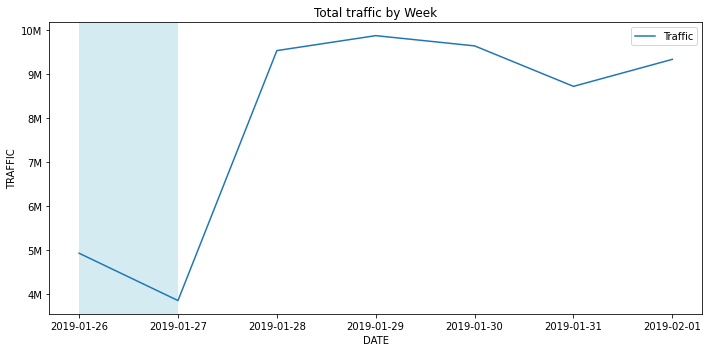

In [113]:
mta_bydate = mta_bystation.groupby('DATE').sum().reset_index()

fig, axs = plt.subplots(nrows=1,figsize=(10,5))

sns.lineplot(data = mta_bydate, x='DATE', y='TRAFFIC', ax=axs, label="Traffic").set(title='Total traffic by Week')

weekend_indices = p1.find_weekend_indices(mta_bydate.DATE.tolist())
p1.highlight_datetimes(weekend_indices, axs, mta_bydate)

axs = plt.gca()
axs.yaxis.set_major_formatter(tick.FuncFormatter(p1.reformat_large_tick_values));

plt.tight_layout()
plt.savefig('weekly_traffic_total-' + str(num_weeks) + 'wk.svg');

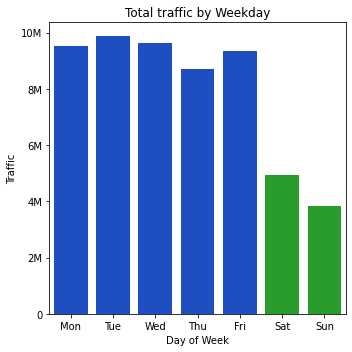

In [114]:
fig, axs = plt.subplots(nrows=1,figsize=(5,5))

with sns.xkcd_palette(['blue', 'blue', 'blue', 'blue', 'blue', 'green', 'green']):
    sns.barplot(data = mta_bystation.groupby('WEEKDAY_INDEX').sum().reset_index(), x='WEEKDAY_INDEX', y='TRAFFIC', ax=axs, label="Traffic").set(title='Total traffic by Weekday', xticklabels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], xlabel='Day of Week', ylabel='Traffic');

axs = plt.gca()
axs.yaxis.set_major_formatter(tick.FuncFormatter(p1.reformat_large_tick_values));

plt.tight_layout()
plt.savefig('weekly_traffic_byweekday-' + str(num_weeks) + 'wk.svg');

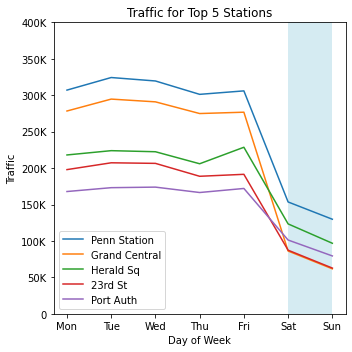

In [132]:
fig, axs = plt.subplots(nrows=1,figsize=(5,5))

for station in mta:
    sns.lineplot(data = mta[station][0], x='WEEKDAY_INDEX', y='TRAFFIC', ax=axs, label=mta[station][1]).set(title='Traffic for Top 5 Stations', ylim=(0,400000), xticklabels=['','Mon','Tue','Wed','Thu','Fri','Sat','Sun'], xlabel='Day of Week', ylabel='Traffic')

axs.axvspan(5, 6, facecolor='lightblue', edgecolor='none', alpha=.5)
        
axs.yaxis.set_major_formatter(tick.FuncFormatter(p1.reformat_large_tick_values))
axs.legend();

plt.tight_layout()
plt.savefig('top5traffic-' + str(num_weeks) + 'wk.svg')

In [116]:
mta_bystation[mta_bystation.STATION == "34 ST-PENN STA"].at[427, 'DATE']

Timestamp('2019-01-26 00:00:00')

In [117]:
mta_bystation[mta_bystation.STATION == "34 ST-PENN STA"].index[0]

427

In [118]:
mta_stations = pd.read_excel("http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls")

In [119]:
mta_stations.head()

,Remote,Booth,Station,Line Name,Division
0,R001,A060,WHITEHALL ST,R1,BMT
1,R001,A058,WHITEHALL ST,R1,BMT
2,R001,R101S,SOUTH FERRY,R1,IRT
3,R002,A077,FULTON ST,ACJZ2345,BMT
4,R002,A081,FULTON ST,ACJZ2345,BMT


### TODO:

- transit data from Feb 2 to Mar 29 2019
    - MVP: week ending Feb 2 2019
- header file for stations/booths (filtering by station)
    - MVP: top 5 stations
- focus on data between 8 am and 8 pm
    - MVP: focus on day (24 hour period)

### Immeadiate tasks:

- combine turnstile and station data
- plot data (day vs vol of passanger)


- combine data from different weeks
- filter/group data by station
- columns: stations, station exits, day of week, number of exits, number of entrances
- determine the difference between REGULAR and RECOVER AUD in DESC column ->> RECOVER AUD adds recovered data after the fact
- group traffic data by stations, see trends on weekdays vs weekends


In [120]:
mta_station_geoloc = pd.read_json("https://data.ny.gov/resource/i9wp-a4ja.json")

In [121]:
mta_station_geoloc.head()

,division,line,station_name,station_latitude,station_longitude,route1,entrance_type,entry,vending,staffing,...,route4,route5,route6,route7,route8,route9,ada_notes,staff_hours,route10,route11
0,BMT,4 Avenue,25th St,40.660397,-73.998091,R,Stair,YES,YES,NONE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BMT,4 Avenue,25th St,40.660397,-73.998091,R,Stair,YES,YES,FULL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BMT,4 Avenue,36th St,40.655144,-74.003549,N,Stair,YES,YES,FULL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BMT,4 Avenue,36th St,40.655144,-74.003549,N,Stair,YES,YES,FULL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BMT,4 Avenue,36th St,40.655144,-74.003549,N,Stair,YES,YES,FULL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
mta_exits_geoloc = pd.read_csv("https://raw.githubusercontent.com/chriswhong/nycturnstiles/master/geocoded.csv", header=None, names=['Remote','Booth', 'Station Name', 'Station ID', 'Division', 'Latitute', 'Longitude'])

In [123]:
mta_exits_geoloc.head()

,Remote,Booth,Station Name,Station ID,Division,Latitute,Longitude
0,R470,X002,ELTINGVILLE PK,Z,SRT,40.544600,-74.164581
1,R544,PTH02,HARRISON,1,PTH,40.738879,-74.155533
2,R165,S102,TOMPKINSVILLE,1,SRT,40.636948,-74.074824
3,R070,S101,ST. GEORGE,1,SRT,40.643738,-74.073622
4,R070,S101A,ST. GEORGE,1,SRT,40.643738,-74.073622


In [124]:
pd.read_csv?

Signature:
pd.read_csv(
    filepath_or_buffer:Union[str, pathlib.Path, IO[~AnyStr]],
    sep=',',
    delimiter=None,
    header='infer',
    names=None,
    index_col=None,
    usecols=None,
    squeeze=False,
    prefix=None,
    mangle_dupe_cols=True,
    dtype=None,
    engine=None,
    converters=None,
    true_values=None,
    false_values=None,
    skipinitialspace=False,
    skiprows=None,
    skipfooter=0,
    nrows=None,
    na_values=None,
    keep_default_na=True,
    na_filter=True,
    verbose=False,
    skip_blank_lines=True,
    parse_dates=False,
    infer_datetime_format=False,
    keep_date_col=False,
    date_parser=None,
    dayfirst=False,
    cache_dates=True,
    iterator=False,
    chunksize=None,
    compression='infer',
    thousands=None,
    decimal:str='.',
    lineterminator=None,
    quotechar='"',
    quoting=0,
    doublequote=True,
    escapechar=None,
    comment=None,
    encoding=None,
    dialect=None,
    error_bad_lines=True,
    warn_bad_lines